In [1]:
import numpy as np
import typing as ty


In [2]:
# Import Process level primitives
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort
from lava.magma.core.process.ports.reduce_ops import ReduceSum

from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires, tag
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.sub.model import AbstractSubProcessModel
from lava.utils.weightutils import SignMode
from lava.proc.dense.process import Dense
from lava.proc.sdn.process import Delta
from lava.proc.lif.process import LIF, AbstractLIF
from lava.proc.monitor.process import Monitor

from lava.proc.io.source import RingBuffer as Input
from lava.proc.lif.models import PyLifModelBitAcc, AbstractPyLifModelFixed, AbstractPyLifModelFloat
from lava.proc.learning_rules.stdp_learning_rule import STDPLoihi



In [3]:
from lava.magma.core.process.process import LogConfig
from numpy import ndarray


class LIF_mod(AbstractLIF):
    """Leaky-Integrate-and-Fire (LIF) neural Process.

    LIF dynamics abstracts to:
    u[t] = u[t-1] * (1-du) + a_in         # neuron current
    v[t] = v[t-1] * (1-dv) + u[t] + bias  # neuron voltage
    s_out = v[t] > vth                    # spike if threshold is exceeded
    v[t] = 0                              # reset at spike

    Parameters
    ----------
    shape : tuple(int)
        Number and topology of LIF neurons.
    u : float, list, numpy.ndarray, optional
        Initial value of the neurons' current.
    v : float, list, numpy.ndarray, optional
        Initial value of the neurons' voltage (membrane potential).
    du : float, optional
        Inverse of decay time-constant for current decay. Currently, only a
        single decay can be set for the entire population of neurons.
    dv : float, optional
        Inverse of decay time-constant for voltage decay. Currently, only a
        single decay can be set for the entire population of neurons.
    bias_mant : float, list, numpy.ndarray, optional
        Mantissa part of neuron bias.
    bias_exp : float, list, numpy.ndarray, optional
        Exponent part of neuron bias, if needed. Mostly for fixed point
        implementations. Ignored for floating point implementations.
    vth : float, optional
        Neuron threshold voltage, exceeding which, the neuron will spike.
        Currently, only a single threshold can be set for the entire
        population of neurons.

    Example
    -------
    >>> lif = LIF(shape=(200, 15), du=10, dv=5)
    This will create 200x15 LIF neurons that all have the same current decay
    of 10 and voltage decay of 5.
    """

    def __init__(
        self,
        *,
        shape: ty.Tuple[int, ...],
        u: ty.Optional[ty.Union[float, list, np.ndarray]] = 0,
        v: ty.Optional[ty.Union[float, list, np.ndarray]] = 0,
        du: ty.Optional[float] = 0,
        dv: ty.Optional[float] = 0,
        bias_mant: ty.Optional[ty.Union[float, list, np.ndarray]] = 0,
        bias_exp: ty.Optional[ty.Union[float, list, np.ndarray]] = 0,
        vth: ty.Optional[float] = 10,
        name: ty.Optional[str] = None,
        log_config: ty.Optional[LogConfig] = None,
        **kwargs,
    ) -> None:
        
        super().__init__(
            shape=shape,
            u=u,
            v=v,
            du=du,
            dv=dv,
            bias_mant=bias_mant,
            bias_exp=bias_exp,
            name=name,
            log_config=log_config,
            **kwargs,
        )

        self.vth = Var(shape=(1,), init=vth)
        self.a_in = InPort(shape=shape,reduce_op=ReduceSum)
        self.s_out = OutPort(shape=shape)
        self.current_out = OutPort(shape=shape)

    def print_vars(self):
        """Prints all variables of a LIF process and their values."""

        sp = 3 * "  "
        print("Variables of the LIF:")
        print(sp + "u:    {}".format(str(self.u.get())))
        print(sp + "v:    {}".format(str(self.v.get())))
        print(sp + "du:   {}".format(str(self.du.get())))
        print(sp + "dv:   {}".format(str(self.dv.get())))
        print(sp + "vth:  {}".format(str(self.vth.get())))   
            
@implements(proc=LIF_mod, protocol=LoihiProtocol)
@requires(CPU)
@tag("floating_pt")
class PyModLifModel(AbstractPyLifModelFloat):

    a_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    current_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    vth: float = LavaPyType(float, float)
        
    def spiking_activation(self):
        """Spiking activation function for LIF."""
        return self.v > self.vth
    
    def run_spk(self):
        super().run_spk()
        self.current_out.send(self.v)

In [4]:

import numpy as np
from lava.magma.core.decorator import implements, requires
from lava.magma.core.resources import CPU
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol

In [5]:
lif1 = LIF_mod(shape=(3,), u=np.random.rand(3)*5, du=0.9, v=1)
dense = Dense(weights=np.eye(3)*2)
lif2 = LIF_mod(shape=(3,), u=np.random.rand(3)*5, du=0.2)
lif1.print_vars()
lif2.print_vars()

Variables of the LIF:
      u:    [2.60197811 4.05954441 0.25942514]
      v:    1
      du:   0.9
      dv:   0
      vth:  10
Variables of the LIF:
      u:    [3.23862109 0.0255828  0.50238695]
      v:    0
      du:   0.2
      dv:   0
      vth:  10


In [6]:
lif1.s_out.connect(dense.s_in)
dense.a_out.connect(lif2.a_in)

In [7]:
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps

run_cfg = Loihi1SimCfg()
lif2.run(condition=RunSteps(num_steps=10), run_cfg=run_cfg)
print(lif2.u.get())
print(lif2.v.get())
#lif2.stop()



[0.34774429 0.00274693 0.05394339]
[1.32577511 0.09134347 1.79377426]


In [8]:
# from lava.magma.compiler.compiler import Compiler
# from lava.magma.core.run_configs import Loihi1SimCfg

# # create a compiler
# compiler = Compiler()

# # compile the Process (and all connected Processes) into an executable
# executable = compiler.compile(lif2, run_cfg=Loihi1SimCfg())

In [9]:
# from lava.magma.runtime.runtime import Runtime
# from lava.magma.core.run_conditions import RunSteps
# from lava.magma.core.process.message_interface_enum import ActorType

# # create and initialize a runtime
# mp = ActorType.MultiProcessing
# runtime = Runtime(exe=executable,
#                   message_infrastructure_type=mp)
# runtime.initialize()

# # start execution
# runtime.start(run_condition=RunSteps(num_steps=100))

# # stop execution
# runtime.stop()

In [10]:
class LsnnNet(AbstractProcess):
    def __init__(self, **params):
        
        super().__init__(**params)
        
        dense_input_weights = params.get("input_weights", np.ones((1,1)))
        dense_recurrent_weights = params.get('recurrent_weights', np.ones((1,1)))
        dense_output_weights = params.get('output_weights', np.ones((1,1)))

        self.dense_input_weights = Var(shape=dense_input_weights.shape, init=dense_input_weights)
        self.dense_output_weights = Var(shape=dense_output_weights.shape, init=dense_output_weights)
        self.dense_recurrent_weights = Var(shape=dense_recurrent_weights.shape, init=dense_recurrent_weights)

        self.s_in  = InPort(shape = (dense_input_weights.shape[1],), reduce_op = ReduceSum)
        self.s_out  = OutPort(shape = (dense_output_weights.shape[0],))
        self.current_b_out = OutPort(shape = (dense_input_weights.shape[0],))
        self.current_f_out = OutPort(shape = (dense_input_weights.shape[0],))
        
        #parameter for forward lif neuron group
        f_u = params.get("f_u",0)
        f_v = params.get("f_v",0)
        f_dv = params.get("f_dv",1)
        f_du = params.get("f_du",0)
        f_bias_exp = params.get("f_bias_exp",0)
        f_bias_mant = params.get("f_bias_mant",0)
        f_vth = params.get("f_vth",1)

        
        self.f_u = Var(shape=(dense_input_weights.shape[0],), init=f_u)
        self.f_v = Var(shape=(dense_input_weights.shape[0],), init=f_v)
        self.f_dv = Var(shape=(1,), init=f_dv)
        self.f_du = Var(shape=(1,), init=f_du)
        self.f_vth = Var(shape=(1,), init=f_vth)
        self.f_bias_exp = Var(shape=(dense_input_weights.shape[0],), init=f_bias_exp) 
        self.f_bias_mant = Var(shape=(dense_input_weights.shape[0],), init=f_bias_mant)
        
        #parameter for backword lif neuron group
        b_u = params.get("b_u",0)
        b_v = params.get("b_v",0)
        b_dv = params.get("b_dv",1)
        b_du = params.get("b_du",0)
        b_bias_exp = params.get("b_bias_exp",0)
        b_bias_mant = params.get("b_bias_mant",0)
        b_vth = params.get("b_vth",10000)

        self.b_u = Var(shape=(dense_input_weights.shape[0],), init=b_u)
        self.b_v = Var(shape=(dense_input_weights.shape[0],), init=b_v)
        self.b_dv = Var(shape=(1,), init=b_dv)
        self.b_du = Var(shape=(1,), init=b_du)
        self.b_vth = Var(shape=(1,), init=b_vth)
        self.b_bias_exp = Var(shape=(dense_input_weights.shape[0],), init=b_bias_exp) 
        self.b_bias_mant = Var(shape=(dense_input_weights.shape[0],), init=b_bias_mant)

        self.log_config = params.get("log_config",0)                                       
        

@implements(proc=LsnnNet, protocol=LoihiProtocol)
class LsnnNetModel(AbstractSubProcessModel):

    s_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    current_f_out : PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    current_b_out : PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)

    def __init__(self, proc):
        """Builds sub Process structure of the Process."""
        
        # Instantiate child processes
        # The input shape is a 2D vector (shape of the weight matrix).
        input_shape = proc.proc_params.get("input_shape", (1,1))
        output_shape = proc.proc_params.get("output_shape", (1,1))

        self.in_dense = Dense(weights=proc.proc_params.get("dense_input_weights", np.ones((1,1))))

        self.f_lif = LIF_mod(shape=(input_shape[1],),
                             u = proc.proc_params.get("f_u", (1,)),
                             v = proc.proc_params.get("f_v", (1,)),
                             dv = proc.proc_params.get("f_dv", 0),
                             du = proc.proc_params.get("f_du", 1),
                             bias_exp= proc.proc_params.get("f_bias_exp", 0),
                             bias_mant=proc.proc_params.get("f_bias_mant", 0),
                             vth=proc.proc_params.get("f_vth", 1),
                             log_config= proc.proc_params.get("log_config", 0)
                             )
        
        self.r_dense = Dense(weights=proc.proc_params.get("dense_recurrent_weights", -0.5*np.ones((1,1))), sign_mode = SignMode.INHIBITORY)
        ### Add minus sign at dense output

        self.b_lif = LIF_mod(shape=(output_shape[1],),
                            u = proc.proc_params.get("b_u", (1,)),
                            v = proc.proc_params.get("b_v", (1,)),
                            dv = proc.proc_params.get("b_dv", 0),
                            du = proc.proc_params.get("b_du", 1),
                            bias_exp= proc.proc_params.get("b_bias_exp", 0),
                            bias_mant=proc.proc_params.get("b_bias_mant", 0),
                            vth=proc.proc_params.get("b_vth", 10000),
                            log_config= proc.proc_params.get("log_config", 0)
                        )
        
        self.out_dense = Dense(weights=proc.proc_params.get("dense_output_weights", np.ones((1,1))))



        proc.in_ports.s_in.connect(self.in_dense.in_ports.s_in)

        self.out_dense.out_ports.a_out.connect(proc.out_ports.s_out)


        self.f_lif.in_ports.a_in.connect_from([self.in_dense.out_ports.a_out,self.b_lif.out_ports.current_out])

        self.f_lif.out_ports.s_out.connect(self.out_dense.in_ports.s_in)

        self.f_lif.out_ports.current_out.connect(self.r_dense.in_ports.s_in)
        
        self.r_dense.out_ports.a_out.connect(self.b_lif.in_ports.a_in)
        ##self.b_lif.out_ports.current_out.connect(self.r_dense.in_ports.s_in)
        self.f_lif.out_ports.current_out.connect(proc.out_ports.current_f_out)
        self.b_lif.out_ports.current_out.connect(proc.out_ports.current_b_out)

        # proc.vars.in_weights.alias(self.in_dense.vars.weights)

        proc.vars.f_u.alias(self.f_lif.vars.u)
        proc.vars.f_v.alias(self.f_lif.vars.v)
        proc.vars.f_bias_mant.alias(self.f_lif.vars.bias_mant)
        proc.vars.f_du.alias(self.f_lif.vars.du)
        proc.vars.f_dv.alias(self.f_lif.vars.dv)
        proc.vars.f_vth.alias(self.f_lif.vars.vth)

        proc.vars.dense_recurrent_weights.alias(self.r_dense.vars.weights)

        proc.vars.b_u.alias(self.b_lif.vars.u)
        proc.vars.b_v.alias(self.b_lif.vars.v)
        proc.vars.b_bias_mant.alias(self.b_lif.vars.bias_mant)
        proc.vars.b_du.alias(self.b_lif.vars.du)
        proc.vars.b_dv.alias(self.b_lif.vars.dv)
        proc.vars.b_vth.alias(self.b_lif.vars.vth)

        proc.vars.dense_output_weights.alias(self.out_dense.vars.weights)
        

In [11]:

        
        

# class DenseLayer(AbstractProcess):
#     """Combines Dense and LIF Processes.
#     """
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
#         shape = kwargs.get("shape", (1, 1))
#         du = kwargs.pop("du", 0)
#         dv = kwargs.pop("dv", 0)
#         bias_mant = kwargs.pop("bias_mant", 0)
#         bias_exp = kwargs.pop("bias_exp", 0)
#         vth = kwargs.pop("vth", 10)
#         weights = kwargs.pop("weights", 0)

#         self.s_in = InPort(shape=(shape[1],))
#         self.s_out = OutPort(shape=(shape[0],))

#         self.weights = Var(shape=shape, init=weights)
#         self.u = Var(shape=(shape[0],), init=0)
#         self.v = Var(shape=(shape[0],), init=0)
#         self.bias_mant = Var(shape=(shape[0],), init=bias_mant)
#         self.du = Var(shape=(1,), init=du)
#         self.dv = Var(shape=(1,), init=dv)
#         self.vth = Var(shape=(1,), init=vth)

# @implements(proc=DenseLayer, protocol=LoihiProtocol)
# class SubDenseLayerModel(AbstractSubProcessModel):

#     def __init__(self, proc):
#         """Builds sub Process structure of the Process."""
        
#         # Instantiate child processes
#         # The input shape is a 2D vector (shape of the weight matrix).
#         shape = proc.proc_params.get("shape", (1, 1))
#         weights = proc.proc_params.get("weights", (1, 1))
#         bias_mant = proc.proc_params.get("bias_mant", (1, 1))
#         vth = proc.proc_params.get("vth", (1, 1))

#         self.dense = Dense(weights=weights)
#         self.lif = LIF(shape=(shape[0], ), bias_mant=bias_mant, vth=vth)
        
#         # Connect the parent InPort to the InPort of the Dense child-Process.
#         proc.in_ports.s_in.connect(self.dense.in_ports.s_in)
        
#         # Connect the OutPort of the Dense child-Process to the InPort of the
#         # LIF child-Process.
#         self.dense.out_ports.a_out.connect(self.lif.in_ports.a_in)
        
#         # Connect the OutPort of the LIF child-Process to the OutPort of the
#         # parent Process.
#         self.lif.out_ports.s_out.connect(proc.out_ports.s_out)

#         proc.vars.u.alias(self.lif.vars.u)
#         proc.vars.v.alias(self.lif.vars.v)
#         proc.vars.bias_mant.alias(self.lif.vars.bias_mant)
#         proc.vars.du.alias(self.lif.vars.du)
#         proc.vars.dv.alias(self.lif.vars.dv)
#         proc.vars.vth.alias(self.lif.vars.vth)
#         proc.vars.weights.alias(self.dense.vars.weights)

In [12]:
t_sim = 100
vth = 0.5

# Interesting input time-series
time = np.arange(t_sim)
inp_data = (np.atleast_2d(np.sin(time / 100 * 2 * np.pi) - 2 * np.sin(time / 100 * 3 * np.pi)) + time / t_sim)


In [13]:
inp = Input(data=inp_data)
inp_proj = Dense(weights=np.eye(1),
                 num_message_bits=8)
delta = Delta(shape=(1, ),
              vth=vth,
              cum_error=True)
net= LsnnNet(f_dv = 0.99, b_dv= 0.99, f_vth = 3)
inp.s_out.connect(inp_proj.s_in)
inp_proj.a_out.connect(net.s_in)
#delta.s_out.connect()

In [14]:
out_p = Monitor()
out_p.probe(net.s_out, t_sim)
b_current_p = Monitor()
b_current_p.probe(net.current_b_out, t_sim)
f_current_p = Monitor()
f_current_p.probe(net.current_f_out, t_sim)
delta_p = Monitor()
delta_p.probe(delta.s_out, t_sim)

In [15]:
from lava.magma.core.run_configs import Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps

run_cfg = Loihi2SimCfg(select_tag='floating_pt')
net.run(condition=RunSteps(num_steps=t_sim), run_cfg=run_cfg)

out_process_key = next(iter(out_p.get_data()))
print (f'{out_process_key=}')
b_current_process_key = next(iter(f_current_p.get_data()))
print (f'{b_current_process_key=}')
f_current_process_key = next(iter(f_current_p.get_data()))
print (f'{f_current_process_key=}')
delta_process_key = next(iter(delta_p.get_data()))
print (f'{delta_process_key=}')

out_values = out_p.get_data()[out_process_key]['s_out']
b_current_values = b_current_p.get_data()[b_current_process_key]['current_b_out']
f_current_values = f_current_p.get_data()[f_current_process_key]['current_f_out']
delta_values = delta_p.get_data()[delta_process_key]['s_out'] 

net.stop()

out_process_key='Process_6'
b_current_process_key='Process_6'
f_current_process_key='Process_6'
delta_process_key='Process_5'


[]

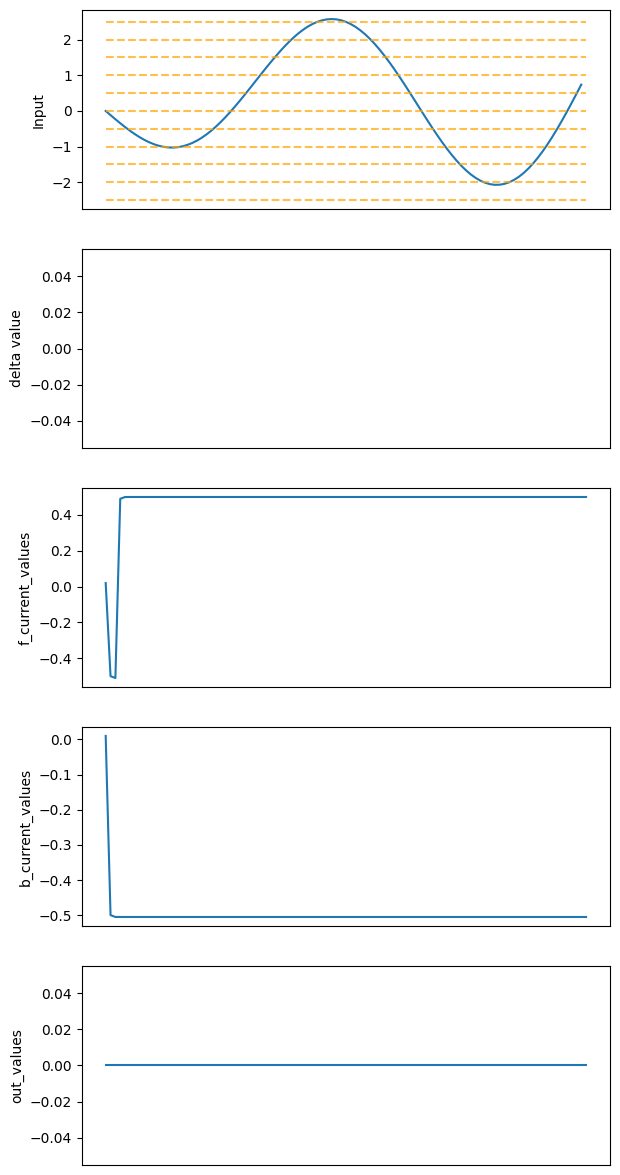

In [16]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(15, 15))

ax = plt.subplot2grid((5, 2), (0, 0))
ax.set_ylabel("Input")
ax.plot(inp_data[0])
ax.hlines(np.arange(np.min(inp_data) // vth, np.max(inp_data) // vth + 1) * vth, 0, t_sim, linestyle='--', alpha=0.7, color='orange')
ax.set_xticks([])

ax = plt.subplot2grid((5, 2), (1, 0))
ax.set_ylabel("delta value")
ax.plot(delta_values)
ax.set_xticks([])

ax = plt.subplot2grid((5, 2), (4, 0))
ax.set_ylabel("out_values")
ax.plot(out_values)
ax.set_xticks([])

ax = plt.subplot2grid((5, 2), (3, 0))
ax.set_ylabel("b_current_values")
ax.plot(b_current_values)
ax.set_xticks([])

ax = plt.subplot2grid((5, 2), (2, 0))
ax.set_ylabel("f_current_values")
ax.plot(f_current_values)
ax.set_xticks([])
